In [511]:
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import os
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import ConvLSTM2D, LSTM, BatchNormalization, Conv3D, Conv2D,Input, Dense, Reshape, Concatenate
from keras.layers import Masking
import yaml
from scipy.interpolate import bisplrep, bisplev, griddata, interp1d

In [ ]:
with open('configs/config_file_covs.yaml') as file:
    params = yaml.safe_load(file)

print(params)

window_size = params['training']['window_size']
patience = params['training']['patience']
epsilon = params['training']['epsilon']
batch_size = params['training']['batch_size']
epochs = params['training']['epochs']

run = params['data']['run']
smooth = params['data']['smooth']
covariate_columns = params['data']['covariates']
option_type = params['data']['option']

learning_rate = params['model']['lr']


h_step = params['forecast']['h_step']

{'training': {'window_size': 21, 'batch_size': 32, 'patience': 15, 'epsilon': 1e-06, 'random_state': 42, 'epochs': 100, 'covariates': 'None', 'smooth': True}, 'model': {'run': 'long_ttm', 'option': 'call', 'filters': 2, 'kernel_size': [2, 2], 'strides': 1, 'kernel_initializer': 'glorot_uniform', 'recurrent_initializer': 'orthogonal', 'optimizer': 'adam', 'lr': 0.001, 'covariates': ['VIX', 'VVIX', 'SKEW', 'RVOL', 'TMS', 'CRS', 'EPU', 'ADS']}, 'forecast': {'h_step': 1}}


In [513]:
# Let's reshape our input data of the thing... we are going to need labels, and we are going to need train surface.
# The labels will be, the smoothed IVs of our data
# The train will be the dimensions, with time x ttm x moneyness encoders
# If we have covariates, the channels will be larger? -> Yes, starting channels will be added to the layers

# Load the data first
if run == 'short_ttm':
    data_train = pd.read_csv('data/final/smoothed/data_train.csv')
    data_val = pd.read_csv('data/final/evaluation/validation_set.csv')
    data_test = pd.read_csv('data/final/evaluation/test_set.csv')

    if option_type =='put':
        data_train[data_train['cp_flag']=='P']
        data_val[data_val['cp_flag']=='P']
        data_test[data_test['cp_flag']=='P']
    elif option_type =='call':
        data_train[data_train['cp_flag']=='C']
        data_val[data_val['cp_flag']=='C']
        data_test[data_test['cp_flag']=='C']

    if covariate_columns is not None:
        covar_df = pd.read_excel('data/final/covariates/covariates_train.xlsx')
        covar_df_val = pd.read_excel('data/final/covariates/covariates_validation.xlsx')

        covar_df = covar_df.rename(columns={'Date':'date'})
        covar_df_val = covar_df_val.rename(columns={'Date':'date'})
        covar_df = covar_df[['date'] + covariate_columns]
        covar_df_val = covar_df_val[['date'] + covariate_columns]

elif run == 'long_ttm':
    data_train = pd.read_csv('data/final/smoothed/data_train_long.csv')
    data_val = pd.read_csv('data/final/evaluation/validation_set_long.csv')
    data_test = pd.read_csv('data/final/evaluation/test_set_long.csv')

    if option_type =='put':
        data_train[data_train['cp_flag']=='P']
        data_val[data_val['cp_flag']=='P']
        data_test[data_test['cp_flag']=='P']
    elif option_type =='call':
        data_train[data_train['cp_flag']=='C']
        data_val[data_val['cp_flag']=='C']
        data_test[data_test['cp_flag']=='C']
        
    if covariate_columns is not None:
        covar_df = pd.read_excel('data/final/covariates/covariates_train_long.xlsx')
        covar_df_val = pd.read_excel('data/final/covariates/covariates_validation_long.xlsx')

        covar_df = covar_df.rename(columns={'Date':'date'})
        covar_df_val = covar_df_val.rename(columns={'Date':'date'})
        covar_df = covar_df[['date'] + covariate_columns]
        covar_df_val = covar_df_val[['date'] + covariate_columns]
   
else:
    print('Select a dataset')


In [514]:
def drop_settlement_dup(df):
    df = df.sort_values(by='am_settlement')
    df = df.drop_duplicates(subset=['maturity', 'moneyness'], keep='first')
    return df

data_train = drop_settlement_dup(data_train)
data_val = drop_settlement_dup(data_val)
data_test = drop_settlement_dup(data_test)

In [515]:
def bin_avg(df, moneyness_grid, bin_width=0.05, train=True):
   
    result = []

    for date in df['date'].unique():
        for maturity in df['maturity'].unique():
            # Filter the data for the current date and maturity
            filtered_df = df[(df['date'] == date) & (df['maturity'] == maturity)]
            
            # Bin each moneyness point within the filtered data
            for center in moneyness_grid:
                lower = center - (bin_width / 2)
                upper = center + (bin_width / 2)

                # Select data points within the current bin
                bin_data = filtered_df[(filtered_df['moneyness'] >= lower) & (filtered_df['moneyness'] < upper)]
                
                if train:
                    avg_iv = bin_data['IV_smooth'].mean() if not bin_data.empty else np.nan
                else:                   
                    avg_iv = bin_data['impl_volatility'].mean() if not bin_data.empty else np.nan

                # Append the result for this combination of date, maturity, and moneyness
                result.append({
                    'date': date,
                    'maturity': maturity,
                    'moneyness': center,
                    'impl_volatility': avg_iv
                })

    # Return the final dataframe with the binned results
    return pd.DataFrame(result)

# Example usage:
moneyness_grid = np.arange(0.80, 1.21, 0.05)  # Example grid


In [516]:
print(data_train.shape)

(4550619, 30)


In [517]:
bins = [0, 21, 63, 126, 189, 270]
labels = [1, 2, 3, 4, 5]

if run =='long_ttm':
    data_train['maturity'] = pd.cut(data_train['maturity'], bins=bins, labels=labels, include_lowest=True, right=True).astype('Int64') 
    data_val['maturity'] = pd.cut(data_val['maturity'], bins=bins, labels=labels, include_lowest=True, right=True).astype('Int64') 
    data_test['maturity'] = pd.cut(data_test['maturity'], bins=bins, labels=labels, include_lowest=True, right=True).astype('Int64') 

    data_train = data_train.dropna(subset=['maturity'])
    data_val = data_val.dropna(subset=['maturity'])
    data_test = data_test.dropna(subset=['maturity'])

In [518]:
print(data_train['maturity'].unique())

<IntegerArray>
[2, 1, 3, 4, 5]
Length: 5, dtype: Int64


In [519]:
data_train = bin_avg(data_train, moneyness_grid, train=smooth)
data_val = bin_avg(data_val, moneyness_grid, train=False)
data_test = bin_avg(data_test, moneyness_grid, train=False)

# make a function write to a data folder, if it exists, then it just reads it, 
# if not, compute and write it out
# following paramters: long/short put/call smooth/no smooth, also which file this is
# data/interpolated 


In [522]:
file_path = 'data/final/binned/data_train_{run}_{option_type}_{smooth}.csv' 
folder_path = 'data/final/binned'

if os.path.isfile(file_path):
    df = pd.read_csv(file_path)
else:
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    data_train.to_csv(f"data/final/binned/data_train_{run}_{option_type}_{smooth}.csv")
    data_val.to_csv(f"data/final/binned/data_val_{run}_{option_type}.csv")
    data_test.to_csv(f"data/final/binned/data_test_{run}_{option_type}.csv")

In [523]:
# for i in data_train['maturity'].unique():
#     print(data_train[data_train['maturity']].shape)

In [524]:
data_train['date'] = pd.to_datetime(data_train['date'])
data_val['date'] = pd.to_datetime(data_val['date'])
data_test['date'] = pd.to_datetime(data_test['date'])
data_train = pd.merge(data_train, covar_df, on='date', how='left')
data_val = pd.merge(data_val, covar_df, on='date', how='left')
data_test = pd.merge(data_test, covar_df, on='date', how='left')

In [525]:
data_train = data_train.dropna()
data_val = data_val.dropna()
data_test = data_test.dropna()

In [526]:
def frame_to_numpy(data, covariate_cols=None, eval=False):
    
    data['time_step'] = data['date']
    time_step_index = pd.to_datetime(data['time_step']).dt.strftime('%Y-%m-%d').unique()
    date_to_index = {date: idx for idx, date in enumerate(time_step_index)}

    data['time_step_str'] = data['time_step'].dt.strftime('%Y-%m-%d')
    data['time_step_idx'] = data['time_step_str'].map(date_to_index)
    #data['time_step_idx'] = data['time_step'].apply(lambda x: np.where(time_step_index == x.strftime('%Y-%m-%d'))[0][0])

    maturity_values = np.sort(data['maturity'].unique())
    maturity_to_idx = {mat: i for i, mat in enumerate(maturity_values)}

    time_steps = len(time_step_index)
    money_dim = len(data['moneyness'].unique())
    ttm_dim = len(maturity_values)

    # Base IV tensor
    IV_array = np.zeros((time_steps, money_dim, ttm_dim, 1))
    cov_array = np.zeros((time_steps, len(covariate_cols)))

    for idx, row in data.iterrows():
        time_step_idx = row['time_step_idx']
        height = int(row['moneyness']) - 1 
        width = maturity_to_idx[row['maturity']]
        value = row['impl_volatility'] if not eval else row['impl_volatility']
        IV_array[time_step_idx, height, width, 0] = value

        for i, cov in enumerate(covariate_cols):
            cov_array[time_step_idx,i] = row[cov]

    return IV_array, cov_array


In [527]:
IV_train, cov_train = frame_to_numpy(data_train, covariate_columns)
IV_val, cov_val = frame_to_numpy(data_val, covariate_columns, eval=True)
IV_test, cov_test = frame_to_numpy(data_test, covariate_columns, eval=True)

In [528]:
def create_rolling_window_dataset(iv_array, cov_array, window_size, h): # hstep ahead here

    T = iv_array.shape[0]
    N = T - window_size - (h - 1)

    x_iv = np.zeros((N, window_size, *iv_array.shape[1:]))        # (N, window_size, H, W, 1)
    x_cov = np.zeros((N, window_size, cov_array.shape[1]))        # (N, window_size, C)
    y = np.zeros((N, *iv_array.shape[1:]))                   # (N, H, W, 1)

    for i in range(N):
        x_iv[i] = iv_array[i:i+window_size]
        x_cov[i] = cov_array[i:i+window_size]
        y[i] = iv_array[i+window_size + (h - 1)]

    return x_iv, x_cov, y
x_iv_train, x_cov_train, target_train = create_rolling_window_dataset(IV_train, cov_train, window_size, h_step)

IV_val_input = np.concatenate((IV_train[-window_size:], IV_val), axis=0)
cov_val_input = np.concatenate((cov_train[-window_size:], cov_val), axis=0)
x_iv_val, x_cov_val, target_val = create_rolling_window_dataset(IV_val_input, cov_val_input, window_size, h_step)

IV_test_input = np.concatenate((IV_val[-window_size:], IV_test), axis=0)
cov_test_input = np.concatenate((cov_val[-window_size:], cov_test))
x_iv_test, x_cov_test, target_test = create_rolling_window_dataset(IV_test_input, cov_test_input, window_size, h_step)


In [529]:
print(x_iv_train.shape, x_cov_train.shape, target_train.shape, IV_train.shape)
print(x_iv_val.shape, x_cov_val.shape, target_val.shape, IV_val.shape, IV_val_input.shape)

(2372, 21, 9, 5, 1) (2372, 21, 8) (2372, 9, 5, 1) (2393, 9, 5, 1)
(217, 21, 9, 5, 1) (217, 21, 8) (217, 9, 5, 1) (217, 9, 5, 1) (238, 9, 5, 1)


In [530]:
time_steps = window_size
height = len(data_train['moneyness'].unique())
width = len(data_train['maturity'].unique())
num_covariates = len(covariate_columns)
SEED = 7582967
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
keras.utils.set_random_seed(SEED)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
tf.config.experimental.enable_op_determinism()
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [531]:
# 1. IV input (spatio-temporal)
iv_input = Input(shape=(time_steps, height, width, 1), name="iv_input")
x_iv = Masking(mask_value=0.0)(iv_input)
x_iv = ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=True)(iv_input)
x_iv = BatchNormalization()(x_iv)
x_iv = ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=False)(x_iv)
x_iv = BatchNormalization()(x_iv)

In [532]:
# 2. Covariate input (temporal only)
cov_input = Input(shape=(time_steps, num_covariates), name="cov_input")

x_cov = LSTM(units=64, return_sequences=False)(cov_input)   # (batch_size, 64)
x_cov = Dense(units=height * width, activation='relu')(x_cov)  
x_cov = Reshape((height, width, 1))(x_cov)               # (batch_size, H, W, 1)


In [533]:
x = Concatenate(axis=-1)([x_iv, x_cov])  # Combine along channel axis -> (H, W, 65)
x = tf.keras.layers.Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid', padding='same')(x)

In [534]:
def masked_mse(y_true, y_pred):
    # obtain true and false objects using tf.not_equal. If it is true, then cast them to 1s, otherwise it is 0
    mask = tf.cast(tf.not_equal(y_true, 0.0), tf.float32)
    # print(mask)

    #Multiply square differences with the mask, so only the 1s are taken into account
    squared_diff = tf.square(y_true - y_pred) * mask

    # sum the amount of 1s
    safe_mask_sum = tf.reduce_sum(mask)

    # sum the amount of square diffences, and divide by total amount 
    return tf.reduce_sum(squared_diff) / safe_mask_sum

In [535]:
model = Model(inputs=[iv_input, cov_input], outputs=x)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=epsilon)
model.compile(loss=masked_mse, optimizer=optimizer)
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 iv_input (InputLayer)          [(None, 21, 9, 5, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv_lstm2d_24 (ConvLSTM2D)    (None, 21, 9, 5, 64  150016      ['iv_input[0][0]']               
                                )                                                                 
                                                                                                  
 cov_input (InputLayer)         [(None, 21, 8)]      0           []                               
                                                                                           

In [537]:
start_time = time.time()

history = model.fit([x_iv_train, x_cov_train], target_train,
          validation_data=([x_iv_val, x_cov_val], target_val),
          epochs=epochs, batch_size=batch_size, shuffle=False,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')])

end_time = time.time()

Epoch 1/100


75/75 [==============================] - 13s 134ms/step - loss: 0.0409 - val_loss: 0.0445
Epoch 2/100
75/75 [==============================] - 10s 129ms/step - loss: 0.0044 - val_loss: 0.0181
Epoch 3/100
75/75 [==============================] - 10s 128ms/step - loss: 0.0034 - val_loss: 0.0053
Epoch 4/100
75/75 [==============================] - 10s 128ms/step - loss: 0.0032 - val_loss: 0.0058
Epoch 5/100
75/75 [==============================] - 10s 129ms/step - loss: 0.0031 - val_loss: 0.0049
Epoch 6/100
75/75 [==============================] - 10s 129ms/step - loss: 0.0029 - val_loss: 0.0040
Epoch 7/100
75/75 [==============================] - 10s 129ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 8/100
75/75 [==============================] - 10s 128ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 9/100
75/75 [==============================] - 10s 129ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 10/100
75/75 [==============================] - 11s 148ms/step - loss: 0.0016 - val_loss

In [538]:
elapsed_time = end_time - start_time
print(f"Time taken to fit the model: {elapsed_time:.2f} seconds")
best_epoch = int(np.argmin(history.history['val_loss']))
best_val_loss = history.history['val_loss'][best_epoch]
print(f"Best Epoch: {best_epoch + 1}, Validation Loss: {best_val_loss:.6f}")
train_loss = history.history['loss']
val_loss = history.history.get('val_loss')

Time taken to fit the model: 454.46 seconds
Best Epoch: 27, Validation Loss: 0.000999


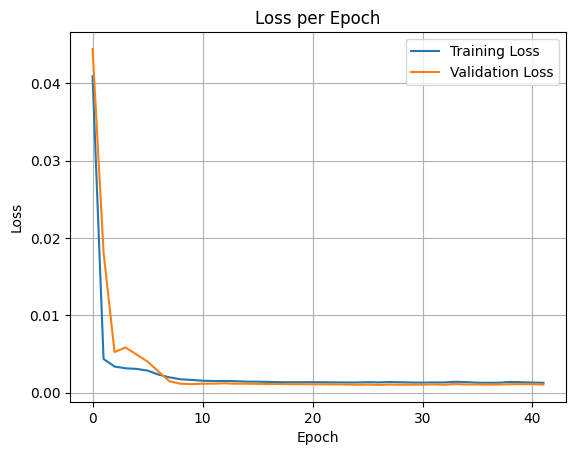

In [539]:
plt.plot(train_loss, label='Training Loss')
if val_loss:
    plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [540]:
# Next step; functions for the IVRMSE and R_oos!!!!!
# H-step ahead performance!!!!!!
# WRITE IT ALL TO RESULTS!!!!!!
# Lower learning rate, beneficial, or leave it? Probably leave it
# All the HYPERPARAMETERS!!!!!! kernel strides, window sizes, parameters, layers, ALL OF THEM
# COVARIATES!!!!!!, Do all the hyperparameters again, and then only save the TEST PERFORMANCE
# MODEL ARCHITECTURE!!!!
# Investigate what happens, if you leave it as 0... We cannot do the interpolation properly, to be frank.

#THEN LONG TERM !!!!!!
# Transformer models!!!!!!!!!!!!!!!!
pred_val = model.predict([x_iv_val, x_cov_val])
pred_test = model.predict([x_iv_test, x_cov_test])

8/8 [==============================] - 0s 29ms/step


In [541]:
# Put it in the compile, but also call it afterward
# double check formula and also make it for R_oos
# Should also work per h-step ahead 
def calculate_ivrmse(y_true, y_pred, all_points=False):

    if not all_points:
        ivrmse = tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))
    else:
        sq_error = tf.square(y_true - y_pred)
        error_surface = tf.reduce_mean(sq_error, axis=[1 , 2])
        ivrmse = tf.sqrt(error_surface)

    return ivrmse.numpy()

In [542]:
def calculate_ivrmse_mask(y_true, y_pred, all_points=False):
    mask = tf.cast(tf.not_equal(y_true, 0.0), tf.double)
    squared_diff = tf.square(y_true - y_pred) * mask
    
    if not all_points:
        mean = tf.reduce_sum(squared_diff) / tf.reduce_sum(mask)
        ivrmse = tf.sqrt(mean)
    else:
        mean = tf.reduce_sum(squared_diff, axis=[1,2]) / tf.reduce_sum(mask, axis=[1,2])
        ivrmse = tf.sqrt(mean)

    return ivrmse.numpy()

# model.compile(optimizer='adam', loss='mse', metrics=[ivrmse_metric])


In [543]:
def calculate_r_oos_mask(y_true, y_pred, all_points=False):

    mask = tf.cast(y_true > 0, tf.double)

    if not all_points:
        ss_res = tf.reduce_sum(tf.square(y_true - y_pred) * mask)

        mean_IV = tf.reduce_sum(y_true * mask, axis = [1, 2], keepdims=True) / tf.reduce_sum(mask, axis=[1, 2], keepdims=True)
        ss_tot = tf.reduce_sum(tf.square(y_true - mean_IV) * mask)
        r2 = 1 - ss_res/ss_tot
    else:
        ss_res = tf.reduce_sum(tf.square(y_true - y_pred)* mask, axis=[1, 2])
        mean_IV = tf.reduce_sum(y_true * mask, axis = [1, 2], keepdims=True) / tf.reduce_sum(mask, axis=[1, 2], keepdims=True)
        ss_tot = tf.reduce_sum(tf.square(y_true - mean_IV) * mask, axis=[1, 2])
        r2 = 1 - ss_res/ss_tot
    return r2.numpy()



In [544]:
def calculate_r_oos(y_true, y_pred, all_points=False):

    if not all_points:
        ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
        mean_IV = tf.reduce_mean(y_true, axis=[1, 2], keepdims=True) # should be shape of 114 long
        ss_tot = tf.reduce_sum(tf.square(y_true - mean_IV))
        
        r2 = 1 - ss_res/ss_tot
    else:
        ss_res = tf.reduce_sum(tf.square(y_true - y_pred), axis=[1, 2])
        mean_IV = tf.reduce_mean(y_true, axis=[1, 2], keepdims=True)
        ss_tot = tf.reduce_sum(tf.square(y_true - mean_IV), axis=[1, 2])
        r2 = 1 - ss_res/ss_tot
    return r2.numpy()

In [545]:
print(calculate_ivrmse(IV_val[h_step-1:], pred_val))
print(calculate_ivrmse_mask(IV_val[h_step-1:], pred_val))
# The loss is less, than in the optimization.. probably a different metric, or formula than mse
# check values of the papers that are like yours
print(calculate_r_oos(IV_val[h_step-1:], pred_val))
print(calculate_r_oos_mask(IV_val[h_step-1:], pred_val))

0.5470898799143672
0.03234056112320752
-36.97720463018481
0.8464392633161898


In [546]:
print(calculate_ivrmse(IV_test[h_step-1:], pred_test))
print(calculate_ivrmse_mask(IV_test[h_step-1:], pred_test))
print(calculate_r_oos(IV_test[h_step-1:], pred_test))
print(calculate_r_oos_mask(IV_test[h_step-1:], pred_test))

0.541313546953784
0.03982437763185066
-20.024192402623797
0.7145047039535157


In [547]:
def get_results(y_real, y_pred):
    ivrmse = calculate_ivrmse_mask(y_real, y_pred)
    ivrmse_h = calculate_ivrmse_mask(y_real, y_pred, all_points=True)
    r_oos = calculate_r_oos_mask(y_real, y_pred)
    r_oos_h = calculate_r_oos_mask(y_real, y_pred, all_points=True)

    return ivrmse, ivrmse_h, r_oos, r_oos_h

In [548]:
def write_results(folder_path, ivrmse, r_oos, ivrmse_h, r_oos_h, surface, surface_pred, covariate_columns, option_type):

    ivrmse_path = folder_path / Path("ivrmse")
    r_oos_path = folder_path / Path("r_oos")
    ivrmse_h_path = folder_path / Path("ivrmse_h")
    r_oos_h_path = folder_path / Path("r_oos_h")
    surface_path = folder_path / Path("surface")
    surface_pred_path = folder_path / Path("surface_pred")

    if not ivrmse_path.exists():
        ivrmse_path.mkdir(parents=True, exist_ok=True)

    if not r_oos_path.exists():
        r_oos_path.mkdir(parents=True, exist_ok=True)

    if not ivrmse_h_path.exists():
        ivrmse_h_path.mkdir(parents=True, exist_ok=True)

    if not r_oos_h_path.exists():
        r_oos_h_path.mkdir(parents=True, exist_ok=True)

    if not surface_path.exists():
        surface_path.mkdir(parents=True, exist_ok=True)

    if not surface_pred_path.exists():
        surface_pred_path.mkdir(parents=True, exist_ok=True)

    cov = ""
    for i in covariate_columns:
        cov = cov+ "_" +i
    np.save(ivrmse_path / f"{option_type}_smooth_{smooth}_ws_{window_size}_h_{h_step}{cov}.npy", ivrmse)
    np.save(r_oos_path / f"{option_type}_smooth_{smooth}_ws_{window_size}_h_{h_step}{cov}.npy", r_oos)
    np.save(ivrmse_h_path / f"{option_type}_smooth_{smooth}_ws_{window_size}_h_{h_step}{cov}.npy", ivrmse_h)
    np.save(r_oos_h_path / f"{option_type}_smooth_{smooth}_ws_{window_size}_h_{h_step}{cov}.npy", r_oos_h)
    np.save(surface_path/ f"{option_type}_smooth_{smooth}_ws_{window_size}_h_{h_step}{cov}.npy", surface)
    np.save(surface_pred_path / f"{option_type}_smooth_{smooth}_ws_{window_size}_h_{h_step}{cov}.npy", surface_pred)

In [ ]:
folder_path = Path(f"results/test_{run}")
ivrmse, ivrmse_h, r_oos, r_oos_h = get_results(IV_test[h_step-1:], pred_test)
write_results(folder_path, ivrmse, r_oos, ivrmse_h, r_oos_h, IV_test[h_step-1:], pred_test, covariate_columns, option_type)

In [ ]:
folder_path = Path(f"results/validation_{run}")
ivrmse, ivrmse_h, r_oos, r_oos_h = get_results(IV_val[h_step-1:], pred_val)
write_results(folder_path, ivrmse, r_oos, ivrmse_h, r_oos_h, IV_val[h_step-1:], pred_test, covariate_columns, option_type)

In [551]:
# For the h-step ahead forecast, an autoregressive approach is used
# Predict the one step ahead forecast (done now)
# After, use this one step ahead forecast in the predict command. 

In [552]:
print(pred_test.shape)

(251, 9, 5, 1)


In [553]:
print(pred_test.shape)

(251, 9, 5, 1)
